# **MODELADO PARA LA PRECIPITACIÓN EN EL ZÓCALO DE PUEBLA**



Precipitación v4:  
https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-monthly
https://www.ncei.noaa.gov/data/ghcnm/v4/precipitation/


Nombres:  
https://www.ncei.noaa.gov/pub/data/ghcn/v4/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(style="whitegrid")

In [3]:
data=pd.read_csv('MXN00021035.csv')

In [67]:
pre=data.iloc[:,6]  # Keep the 7th column (the one with the date)
date=data.iloc[:,5] # Keep the 6th column (the one with the temperature)
date = date.astype(str).str.replace(r'(\d{4})(\d{2})', r'\1/\2', regex=True)    # From 195210 to 1952/10 
date = pd.to_datetime(date, format='%Y/%m')# Convert the date column to datetime

In [65]:
date

0     1952-10-01
1     1952-11-01
2     1952-12-01
3     1953-04-01
4     1953-05-01
         ...    
667   2009-08-01
668   2009-09-01
669   2009-10-01
670   2009-11-01
671   2009-12-01
Name: 195209, Length: 672, dtype: datetime64[ns]

In [68]:
pre

0       174
1       592
2         0
3        47
4       137
       ... 
667    1474
668    3161
669    1190
670     155
671      51
Name:   1927, Length: 672, dtype: int64

In [77]:
pre = pd.Series(pre.values, index=date) # Create a new Series with the date as index
pre

195209
1952-10-01     174
1952-11-01     592
1952-12-01       0
1953-04-01      47
1953-05-01     137
              ... 
2009-08-01    1474
2009-09-01    3161
2009-10-01    1190
2009-11-01     155
2009-12-01      51
Length: 672, dtype: int64

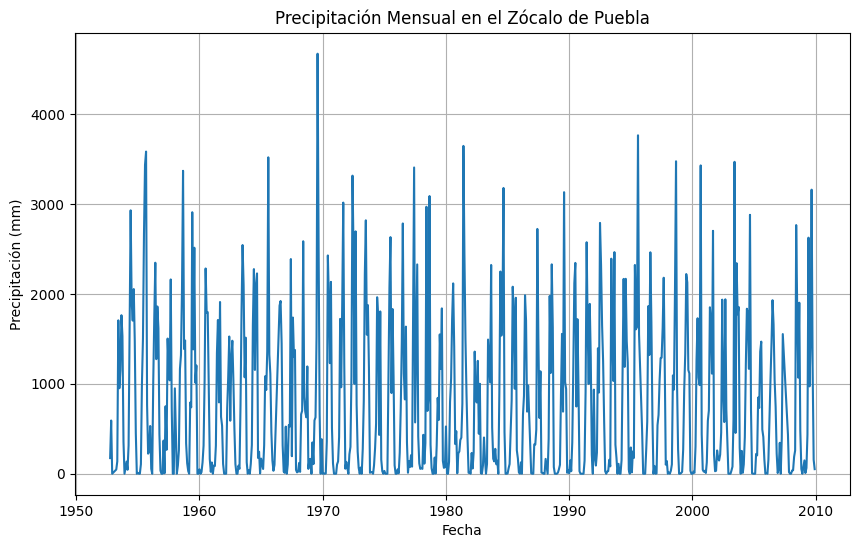

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(pre)
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.title("Precipitación Mensual en el Zócalo de Puebla")
plt.grid(True)
plt.show()

# **TRANSFORMACIÓN**

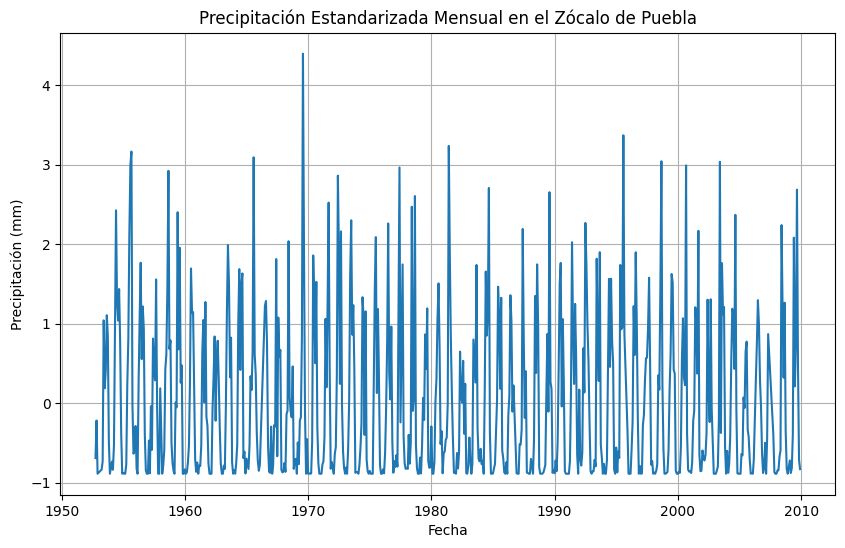

In [78]:
# estandarizar la serie
zpre = (pre - pre.mean()) / pre.std()

# graficar la serie estandarizada
plt.figure(figsize=(10, 6))
plt.plot(zpre)
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.title("Precipitación Estandarizada Mensual en el Zócalo de Puebla")
plt.grid(True)
plt.show()

# **ESTACIONARIEDAD**

In [8]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(zpre)

(-6.217559258126873,
 5.319944160548207e-08,
 11,
 660,
 {'1%': -3.440296841949105,
  '5%': -2.8659291016222834,
  '10%': -2.569107357667585},
 10188.524149780042)

In [ ]:
estacionariedad = adfuller(zpre)

if estacionariedad[1] < 0.05:
    print("La serie es estacionaria", estacionariedad[1])

La serie es estacionaria 5.319944160548207e-08


## **AUTOCORRELACIONES**

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.pyplot as plt

### **Autocorrelaciones Simples**

In [13]:
autocorr_values = acf(pre, nlags=24)    # get the autocorrelations
autocorr_values = autocorr_values[1:]   # drop the first value (lag 0)

print(autocorr_values)

[ 0.50839258  0.23418155  0.01313411 -0.30708039 -0.52560174 -0.57512638
 -0.45457715 -0.24676928  0.05574702  0.28668487  0.51873702  0.62104148
  0.4223674   0.18726716 -0.05027177 -0.31533739 -0.51101384 -0.52356076
 -0.41372522 -0.19536916  0.07490439  0.29360553  0.49171041  0.55390038]


In [14]:
acf(pre, nlags=24)[1:] 

array([ 0.50839258,  0.23418155,  0.01313411, -0.30708039, -0.52560174,
       -0.57512638, -0.45457715, -0.24676928,  0.05574702,  0.28668487,
        0.51873702,  0.62104148,  0.4223674 ,  0.18726716, -0.05027177,
       -0.31533739, -0.51101384, -0.52356076, -0.41372522, -0.19536916,
        0.07490439,  0.29360553,  0.49171041,  0.55390038])

In [15]:
def significancia(N, rhos):
    return 2 * np.sqrt(1 / (N) * (1 + 2 * sum(rho**2 for rho in rhos)))

In [16]:
def FAC(N: int, rhos: list, print_rhos: bool = False) -> list:
    """
    Nos da la lista de los rhos significativos
    """
    significativos = []
    rho_list = [0] * len(rhos)
    
    updated_rhos = list(rho_list)  # Copy to retain original values when updating
    for i, r in enumerate(rhos):  # for index, rho in enumerate(r_list):
        threshold_value = significancia(N, updated_rhos)    # se actualiza el valor con los rhos significativos
        if abs(r) > threshold_value:
            if print_rhos: 
                print(f"rho {i+1} es significativo")
                print(f"{abs(r)} > {threshold_value}\n")

            updated_rhos[i] = r
            significativos.append((r, i+1))
        else:
            if print_rhos: 
                print(f"rho {i+1} no es significativo")
                print(f"{abs(r)} < {threshold_value}\n")

    print("Valores de autocorrelacion significativos:")
    for val, i in significativos:
        print(f"r{i}: {val}")

    return updated_rhos, significativos

In [17]:
val_autocorr_sig, autocorr_sig = FAC(len(pre), autocorr_values) # Valores de autocorrelacion significativos, Autocorrelaciones significativas

Valores de autocorrelacion significativos:
r1: 0.5083925816973088
r2: 0.23418154549209608
r4: -0.3070803907540978
r5: -0.5256017392698511
r6: -0.5751263827263252
r7: -0.45457715127908516
r8: -0.24676927683898547
r10: 0.2866848720759363
r11: 0.5187370197972071
r12: 0.6210414783053101
r13: 0.42236739598057454
r14: 0.1872671581270487
r16: -0.31533738829001007
r17: -0.5110138375479141
r18: -0.5235607578669751
r19: -0.4137252180674526
r22: 0.2936055261454964
r23: 0.4917104080324355
r24: 0.5539003811525877


### **Autocorrelaciones Simples**

In [18]:
pacf_values = pacf(pre, nlags=24)
pacf_values = pacf_values[1:]       # drop the first value (lag 0)
print(pacf_values)

[ 0.50915025 -0.03287594 -0.12647798 -0.35612797 -0.33894795 -0.27403763
 -0.13857567 -0.08223542  0.05576356  0.01318253  0.19534353  0.25851008
  0.02594096 -0.00088725  0.01740651 -0.00537288 -0.06427178 -0.05420949
 -0.07395753 -0.03629151 -0.02303549 -0.04347716  0.04677814  0.11135938]


In [19]:
def intervalo(N):
    "Esta es de las autocorrelaciones parciales"
    return 2*np.sqrt(1/ N)

In [20]:
def FACP(N: int, rho_list: list, print_rhos: bool = False) -> list:
    """
    Esta función nos da la lista de los rhos significativos
    """
    
    fueradelintervalo = intervalo(N)
    significativos = []

    for i, r in enumerate(rho_list):
        
        if abs(r) > fueradelintervalo:
            if print_rhos: 
                print(f"rho {i+1} es significativo")
                print(f"{abs(r)} > {fueradelintervalo}\n")
            significativos.append((r, i+1))
        else:
            if print_rhos: 
                print(f"rho {i+1} no es significativo")
                print(f"{abs(r)} < {fueradelintervalo}\n")
                pass

    print(f"Valores de autocorrelacion parcial significativos:")
    for r, i in significativos:
        print(f"rho {i}: {r}")

    return significativos

In [21]:
facp_sig = FACP(len(pre), pacf_values)

Valores de autocorrelacion parcial significativos:
rho 1: 0.5091502457534897
rho 3: -0.12647798109479702
rho 4: -0.3561279660010308
rho 5: -0.3389479485953009
rho 6: -0.2740376325288502
rho 7: -0.13857567141649174
rho 8: -0.0822354191788456
rho 11: 0.19534353456529416
rho 12: 0.2585100818536458
rho 24: 0.11135938181397918


## **plot**

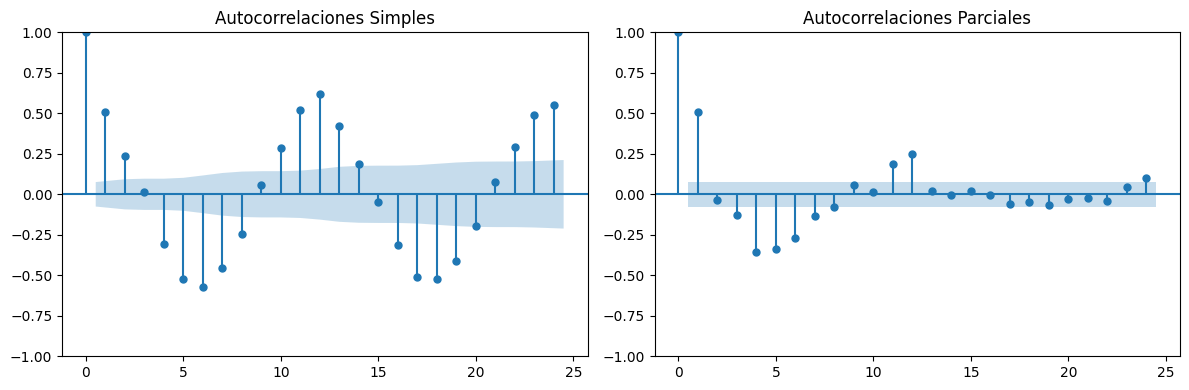

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(pre, lags=24, ax=axs[0])
# axs[0].set_ylim(-0.04, 0.04)
axs[0].set_title('Autocorrelaciones Simples')

plot_pacf(pre, lags=24, ax=axs[1])
# axs[1].set_ylim(-0.04, 0.04)
axs[1].set_title('Autocorrelaciones Parciales')

plt.tight_layout()
plt.show()


In [23]:
fac = FAC(len(pre), acf(pre, nlags=24)[1:] )

Valores de autocorrelacion significativos:
r1: 0.5083925816973088
r2: 0.23418154549209608
r4: -0.3070803907540978
r5: -0.5256017392698511
r6: -0.5751263827263252
r7: -0.45457715127908516
r8: -0.24676927683898547
r10: 0.2866848720759363
r11: 0.5187370197972071
r12: 0.6210414783053101
r13: 0.42236739598057454
r14: 0.1872671581270487
r16: -0.31533738829001007
r17: -0.5110138375479141
r18: -0.5235607578669751
r19: -0.4137252180674526
r22: 0.2936055261454964
r23: 0.4917104080324355
r24: 0.5539003811525877


In [24]:
facp = FACP(len(pre), pacf(pre, nlags=24)[1:])

Valores de autocorrelacion parcial significativos:
rho 1: 0.5091502457534897
rho 3: -0.12647798109479702
rho 4: -0.3561279660010308
rho 5: -0.3389479485953009
rho 6: -0.2740376325288502
rho 7: -0.13857567141649174
rho 8: -0.0822354191788456
rho 11: 0.19534353456529416
rho 12: 0.2585100818536458
rho 24: 0.11135938181397918


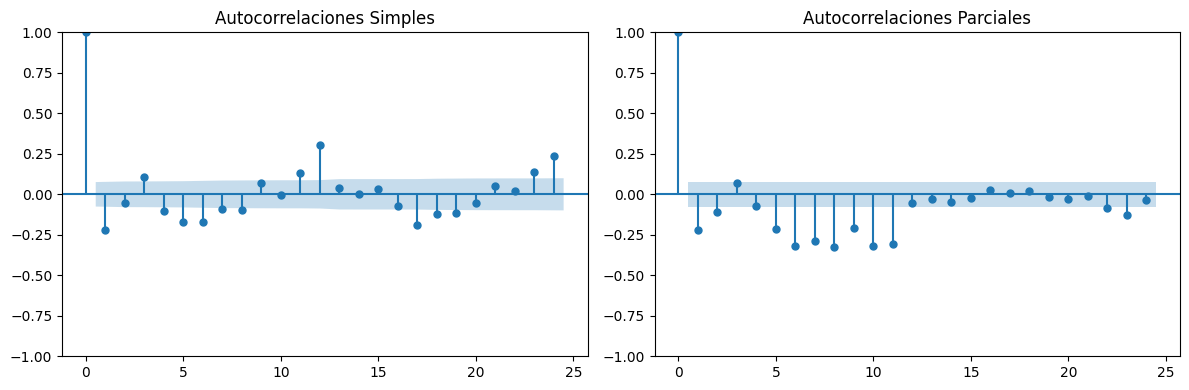

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(zpre, lags=24, ax=axs[0])
# axs[0].set_ylim(-0.04, 0.04)
axs[0].set_title('Autocorrelaciones Simples')

plot_pacf(zpre, lags=24, ax=axs[1])
# axs[1].set_ylim(-0.04, 0.04)
axs[1].set_title('Autocorrelaciones Parciales')

plt.tight_layout()
plt.show()


In [ ]:
fac = FAC(len(zpre), acf(zpre, nlags=24)[1:] )

Valores de autocorrelacion significativos:
r1: -0.2208552382670341
r3: 0.10390830525106899
r4: -0.1059125095712042
r5: -0.17103827520973158
r6: -0.17182021910195022
r7: -0.09179592411826668
r8: -0.09629819587421841
r11: 0.13167076342070386
r12: 0.30671463810829047
r17: -0.1866969636398212
r18: -0.12361634021919933
r19: -0.1137327163527698
r23: 0.13844098837093044
r24: 0.2342564653224263


In [ ]:
facp = FACP(len(zpre), pacf(zpre, nlags=24)[1:])

Valores de autocorrelacion parcial significativos:
rho 1: -0.2211848729510148
rho 2: -0.10774677077439372
rho 5: -0.21590129461409885
rho 6: -0.31940094915194445
rho 7: -0.2955195914988785
rho 8: -0.3311470047776021
rho 9: -0.21864855964375954
rho 10: -0.3337070293585946
rho 11: -0.34113912250088874
rho 12: -0.09392430761753182
rho 14: -0.08270696913668538
rho 22: -0.102153953558673
rho 23: -0.15928203014308834


## **MODELADO**

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
modelo=SARIMAX(pre,
               order=(1,0,1),
               seasonal_order=(1,0,0,12)).fit()

modelo.summary()

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                1927   No. Observations:                  672
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -5346.945
Date:                             Tue, 22 Apr 2025   AIC                          10701.891
Time:                                     10:14:29   BIC                          10719.932
Sample:                                          0   HQIC                         10708.878
                                             - 672                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   8950.475      0.000       1.000       1.000
ma.L1         -0.9994      0.026    -38.058      0.000      -1.051      -0.948
ar.S.L12       0.6336      0.025     25.836      0.000       0.586       0.682
sigma2      4.685e+05   3.29e-08   1.43e+13      0.000    4.68e+05    4.68e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.73   Jarque-Bera (JB):               448.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             1.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.66e+27. Standard errors may be unstable.
"""

In [30]:
modelo=SARIMAX(dpre,
               order=(1,0,1),
               seasonal_order=(1,0,1,12)).fit()

modelo.summary()

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               1927   No. Observations:                  671
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -5279.792
Date:                            Tue, 22 Apr 2025   AIC                          10569.584
Time:                                    10:14:30   BIC                          10592.128
Sample:                                         0   HQIC                         10578.315
                                            - 671                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1890      0.031      6.098      0.000       0.128       0.250
ma.L1         -1.0000      0.036    -27.734      0.000      -1.071      -0.929
ar.S.L12       0.9247      0.018     52.585      0.000       0.890       0.959
ma.S.L12      -0.6111      0.034    -17.808      0.000      -0.678      -0.544
sigma2      3.929e+05   9.17e-08   4.28e+12      0.000    3.93e+05    3.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               332.23
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.97
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.36e+26. Standard errors may be unstable.
"""

In [80]:
modelo=SARIMAX(zpre,
               order=(1,0,0),
               seasonal_order=(4,0,0,12)).fit()

modelo.summary()

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  672
Model:             SARIMAX(1, 0, 0)x(4, 0, 0, 12)   Log Likelihood                -726.886
Date:                            Tue, 22 Apr 2025   AIC                           1465.772
Time:                                    10:41:17   BIC                           1492.833
Sample:                                         0   HQIC                          1476.252
                                            - 672                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1769      0.031      5.728      0.000       0.116       0.237
ar.S.L12       0.3271      0.027     12.028      0.000       0.274       0.380
ar.S.L24       0.1687      0.032      5.263      0.000       0.106       0.232
ar.S.L36       0.2019      0.033      6.149      0.000       0.138       0.266
ar.S.L48       0.0783      0.035      2.241      0.025       0.010       0.147
sigma2         0.5028      0.018     27.726      0.000       0.467       0.538
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               339.29
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.99
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

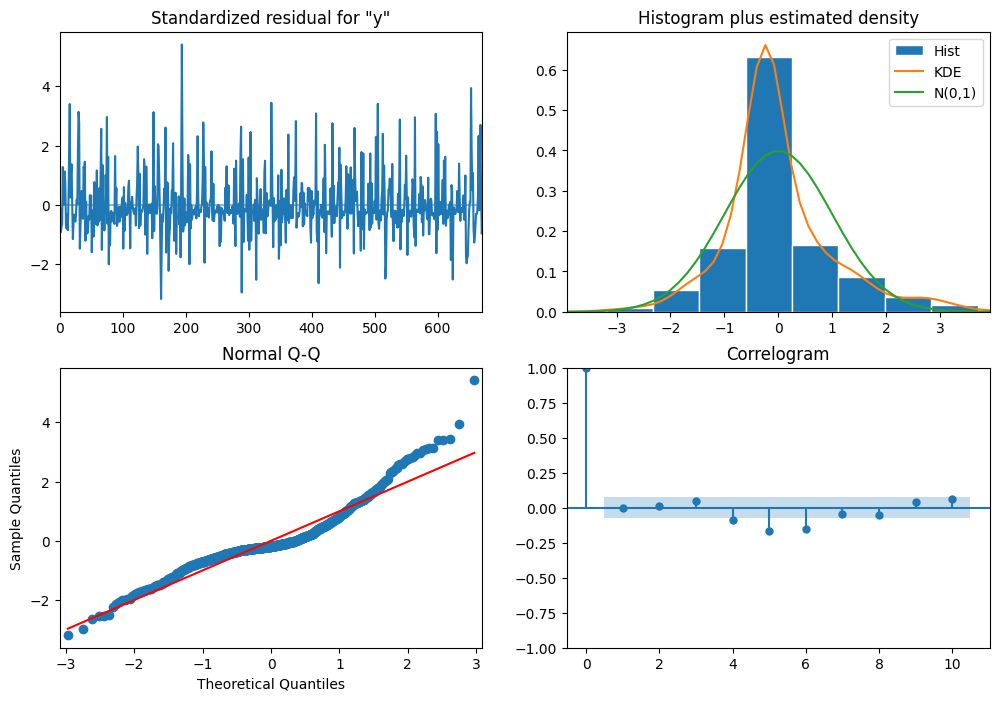

In [81]:
diagnostic = modelo.plot_diagnostics(figsize=(12, 8))
plt.show()

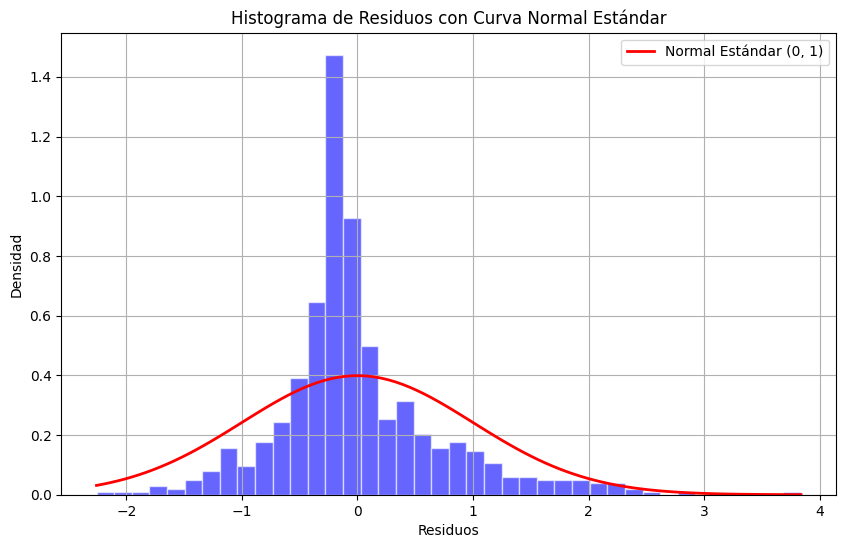

In [82]:
# Importar la función para la distribución normal
from scipy.stats import norm
import numpy as np

# Graficar el histograma de los residuos
plt.figure(figsize=(10, 6))
modelo.resid.hist(bins=40, density=True, alpha=0.6, color='blue', edgecolor='white')

# Generar valores para la curva normal estándar
x = np.linspace(modelo.resid.min(), modelo.resid.max(), 100)
normal_pdf = norm.pdf(x, loc=0, scale=1)  # Media 0, desviación estándar 1

# Graficar la curva normal estándar
plt.plot(x, normal_pdf, 'r-', lw=2, label='Normal Estándar (0, 1)')

# Etiquetas y leyenda
plt.title("Histograma de Residuos con Curva Normal Estándar")
plt.xlabel("Residuos")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

# **una libreria que busca el mejor ARIMA**

In [35]:
import pmdarima as pm

# Find the best SARIMA model
auto_sarima_model = pm.auto_arima(zpre, 
                                  seasonal=True, 
                                  m=12,  # Monthly data, so seasonality is 12
                                  stepwise=True, 
                                  suppress_warnings=True, 
                                  trace=True)

# Display the summary of the best model
auto_sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1910.053, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1547.790, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1630.749, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1908.053, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1710.994, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1500.606, Time=0.82 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1464.747, Time=1.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1462.748, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1615.504, Time=0.13 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=1464.747, Time=1.08 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1583.500, Time=0.56 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1482.914, Time=0.28 sec
 ARIMA(2,0,0)(1,0,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  672
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -726.375
Date:                              Tue, 22 Apr 2025   AIC                           1460.749
Time:                                      10:15:54   BIC                           1478.790
Sample:                                           0   HQIC                          1467.736
                                              - 672                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1886      0.031      6.077      0.000       0.128       0.249
ar.S.L12       0.9221      0.018     52.445      0.000       0.888       0.957
ma.S.L12      -0.6093      0.035    -17.584      0.000      -0.677      -0.541
sigma2         0.5022      0.018     27.804      0.000       0.467       0.538
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               343.91
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.99
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
modelo=SARIMAX(zpre,
               order=(1,0,0),
               seasonal_order=(1,0,1,12)).fit()

modelo.summary()

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  672
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -726.375
Date:                              Tue, 22 Apr 2025   AIC                           1460.749
Time:                                      10:41:38   BIC                           1478.790
Sample:                                           0   HQIC                          1467.736
                                              - 672                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1886      0.031      6.077      0.000       0.128       0.249
ar.S.L12       0.9221      0.018     52.445      0.000       0.888       0.957
ma.S.L12      -0.6093      0.035    -17.584      0.000      -0.677      -0.541
sigma2         0.5022      0.018     27.804      0.000       0.467       0.538
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               343.91
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.99
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

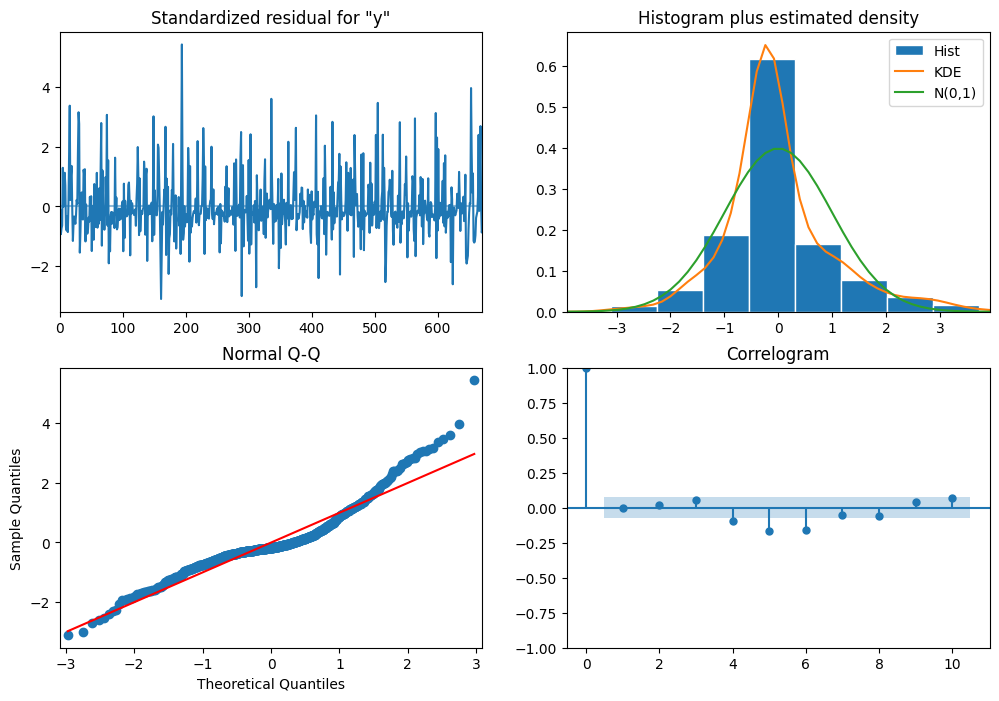

In [84]:
diagnostic = modelo.plot_diagnostics(figsize=(12, 8))
plt.show()

In [96]:
residuos = modelo.resid

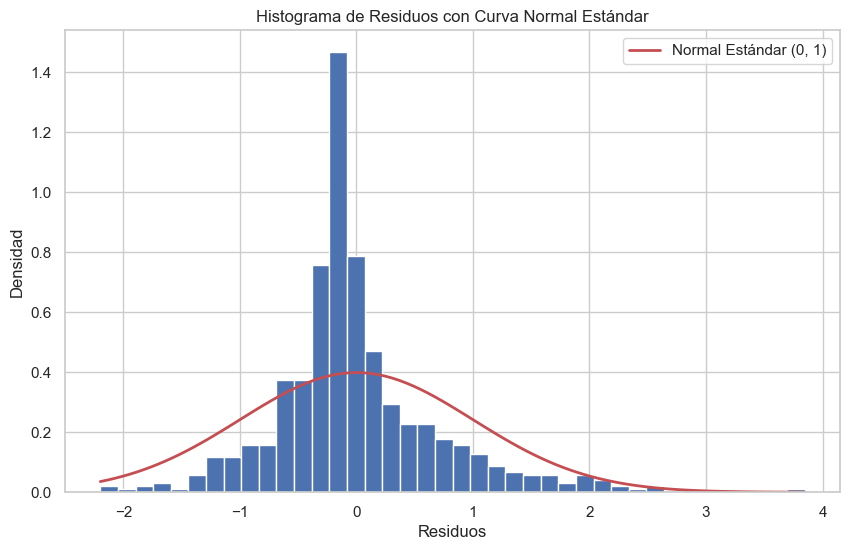

In [118]:
# Importar la función para la distribución normal
from scipy.stats import norm
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# Graficar KDE de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=40, density=True, edgecolor='white')

# Generar valores para la curva normal estándar
x = np.linspace(modelo.resid.min(), modelo.resid.max(), 100)
normal_pdf = norm.pdf(x, loc=0, scale=1)  # Media 0, desviación estándar 1

# Graficar la curva normal estándar
plt.plot(x, normal_pdf, 'r-', lw=2, label='Normal Estándar (0, 1)')

# Etiquetas y leyenda
plt.title("Histograma de Residuos con Curva Normal Estándar")
plt.xlabel("Residuos")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [90]:
zpre

195209
1952-10-01   -0.691618
1952-11-01   -0.218798
1952-12-01   -0.888438
1953-04-01   -0.835274
1953-05-01   -0.733470
                ...   
2009-08-01    0.778874
2009-09-01    2.687121
2009-10-01    0.457628
2009-11-01   -0.713110
2009-12-01   -0.830749
Length: 672, dtype: float64

In [ ]:
# Pronóstico para 12 meses hacia el futuro
forecast = modelo.forecast(steps=12)

c:\Users\herie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Obtener pronóstico con intervalos
pred = modelo.get_forecast(steps=12)

In [129]:
# Media pronosticada
forecast_mean = pred.predicted_mean
forecast_mean

672   -0.326292
673   -0.421722
674   -0.643396
675   -0.645621
676   -0.482450
677    0.862152
678    0.059182
679    0.174146
680    1.212028
681    0.187815
682   -0.324822
683   -0.380758
Name: predicted_mean, dtype: float64

In [133]:
# Intervalos de confianza
int_conf = pred.conf_int()
int_conf


,lower y,upper y
672,-1.715186,1.062603
673,-1.835111,0.991668
674,-2.057650,0.770857
675,-2.059905,0.768663
676,-1.896735,0.931835
677,-0.552133,2.276437
678,-1.355103,1.473467
679,-1.240139,1.588431
680,-0.202258,2.626313
681,-1.226470,1.602100


In [128]:
forecast_real = forecast_mean * pre.std() + pre.mean()
forecast_real

672     496.969487
673     412.603500
674     216.630423
675     214.663500
676     358.916443
677    1547.622176
678     837.750122
679     939.385158
680    1856.932380
681     951.469261
682     498.269070
683     448.818293
Name: predicted_mean, dtype: float64

In [134]:
int_conf_real = int_conf * pre.std() + pre.mean()
int_conf_real

,lower y,upper y
672,-730.893459,1724.832433
673,-836.914443,1662.121442
674,-1033.651174,1466.912020
675,-1035.645262,1464.972262
676,-891.393285,1609.226172
677,297.312413,2797.931938
678,-412.559643,2088.059886
679,-310.924606,2189.694922
680,606.622616,3107.242144
681,-298.840503,2201.779025


In [156]:
# Generate forecast dates and plot forecast series
forecast_index = pd.date_range(start=pre.index[-2], periods=13, freq='ME')[1:]

In [157]:
forecast_index

DatetimeIndex(['2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30'],
              dtype='datetime64[ns]', freq='ME')

C:\Users\herie\AppData\Local\Temp\ipykernel_19860\3043296314.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=pre.index[-1], periods=12+1, freq='M')[1:] # Generar fechas para el pronóstico


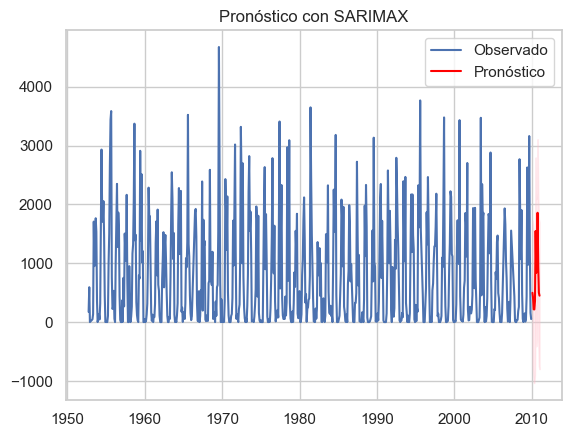

In [ ]:
# Serie original
plt.plot(pre, label='Observado')

# Pronóstico
forecast_index = pd.date_range(start=pre.index[-1], periods=12+1, freq='M')[1:] # Generar fechas para el pronóstico
plt.plot(forecast_index, forecast_real, label='Pronóstico', color='red')    # Pronóstico en rojo

# Intervalos
plt.fill_between(forecast_index, 
                 int_conf_real.iloc[:, 0], 
                 int_conf_real.iloc[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.title('Pronóstico con SARIMAX') 
plt.show()

In [148]:
pre

195209
1952-10-01     174
1952-11-01     592
1952-12-01       0
1953-04-01      47
1953-05-01     137
              ... 
2009-08-01    1474
2009-09-01    3161
2009-10-01    1190
2009-11-01     155
2009-12-01      51
Length: 672, dtype: int64

C:\Users\herie\AppData\Local\Temp\ipykernel_19860\3533619256.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=pre.index[-2], periods=13, freq='M')[1:]


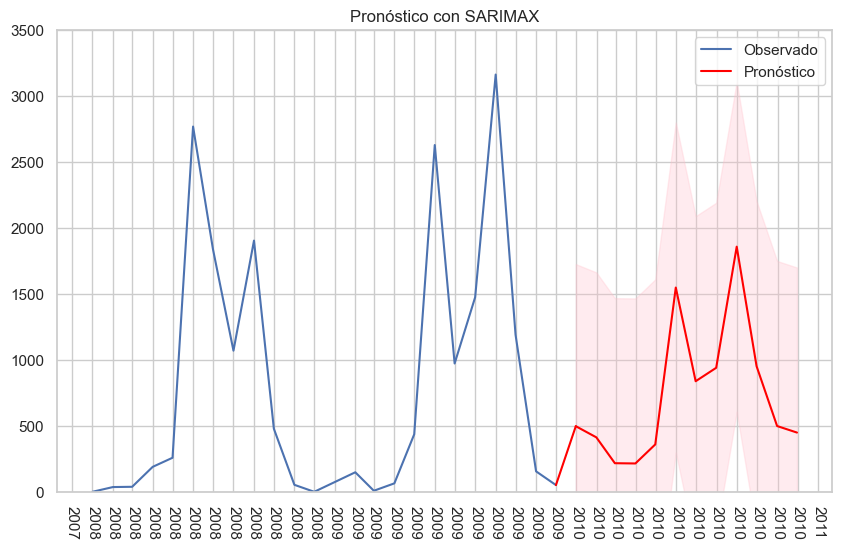

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # set ticks every month

# Filter the observed series from 2008 onward
obs = pre[pre.index >= '2008-01-01']

# Plot the observed series
plt.plot(obs, label='Observado')


plt.plot(forecast_index, forecast_real, label='Pronóstico', color='red')

# Add a red line connecting the last observed point with the first forecast point
last_obs_date = obs.index[-1]
last_obs_value = obs.iloc[-1]
first_fc_date = forecast_index[0]
first_fc_value = forecast_real.iloc[0]
plt.plot([last_obs_date, first_fc_date], [last_obs_value, first_fc_value], color='red', 
         linestyle='-', linewidth=1.5)

# Plot the forecast intervals
plt.fill_between(forecast_index, 
                 int_conf_real.iloc[:, 0], 
                 int_conf_real.iloc[:, 1], color='pink', alpha=0.3)

plt.xticks(rotation=270)
plt.legend()
plt.title('Pronóstico con SARIMAX')
plt.ylim(0, 3500)
plt.grid(True)
plt.show()